In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import corner
from scipy import integrate, interpolate
import emcee

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/Astro/Code/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/cloudy_grids/'

In [4]:
z_sys = 1.09456549

In [5]:
savedir = '/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z=1.09456549/cloudy_fits/'

Obtain the UVB grid from FG20

In [6]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'fg20_galaxy.ascii')

Fetch the SED at $z=1$

In [7]:
z_test = 1

In [8]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify $N_{\mathrm{HI}}$ grid points and get corresponding filenames

In [9]:
logN_HI_min = 12
logN_HI_max = 17
logN_HI_step = 0.25

logN_HI_arr = np.arange(logN_HI_min, logN_HI_max+logN_HI_step, logN_HI_step)

In [10]:
file_list = create_grid_file_list(logN_HI_arr)

Specify grid points for densities and metallicities

In [11]:
log_hdens_min = -5
log_hdens_max = 1
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)
logU_arr = np.log10(calc_U(fg20_wav_grid, fg20_J_nu_test, 10**log_hdens_arr))

In [12]:
log_metals_min = -3
log_metals_max = 1
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load the final grid

In [13]:
pkl_file = open(rootdir+'final_grid.pkl', 'rb')
species_logN_samples = pickle.load(pkl_file)
pkl_file.close()

Interpolate this grid

In [14]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((logN_HI_arr, log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

# Line width trend

In [15]:
b_dict = {'HI':'21, -3, +2',
          'CIII':'18.0, -0.3, +0.3',
          'CIV':'18.0, -0.3, +0.3',
          'NIV':'13, -5, +6',
          'OIII':'25, -4, +4',
          'OIV':'23, -1, +1',
          'OV':'26, -2, +2',
          'OVI':'13, -5, +7'}

(6.5, 31.0)

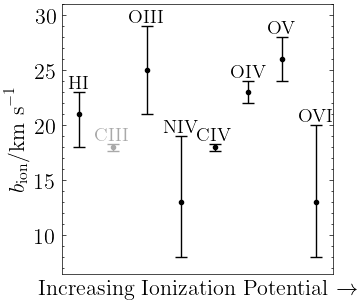

In [16]:
fig, ax = plt.subplots(1, figsize=(3.5,3.5))

plot_linewidth_obs(b_dict, fig, ax, fs=14, gray_out=['CIII'])

ax.set_xlim(-0.5, len(b_dict)-1+0.5)
ax.set_ylim(6.5,31)

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_lw.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

# Column density ratios

In [17]:
logN_dict = {'HI':'14.5, -0.1, +0.2',
            'HeI':'<13.2',
            'CII':'<13.5',
            'CIII':'14.4, -0.1, +0.1',
            'CIV':'13.97, -0.01, +0.01',
            'NII':'<13.5',
            'NIV':'13.1, -0.1, +0.1',
            'NV':'<13.5',
            'OII':'<13.5',
            'OIII':'14.22, -0.05, +0.05',
            'OIV':'14.67, -0.02, +0.02',
            'OV':'14.20, -0.04, +0.04',
            'OVI':'13.8, -0.1, +0.1',
            'NeVI':'<13.8',
            'NeVIII':'<13.8',
            'MgII':'<11.4',
            'MgX':'<13.9',
            'AlII':'<11.2',
            'AlIII':'<11.6',
            'SiII':'<12.3',
            'SiIII':'<12.4',
            'SIV':'<13.0',
            'SV':'<12.7',
            'SVI':'<13.7',
            'FeII':'<11.8',}

In [18]:
gen_logN_ratio_str(logN_dict['OVI'], logN_dict['OV'])

'-0.40, -0.11, 0.11'

In [19]:
logN_ratio_dict = {'CIV/CIII': '-0.44, -0.10, 0.10',
                   'OV/OIV': '-0.47, -0.04, 0.04',
                   #'OIV/OIII': '0.45, -0.05, 0.05',
                   #'HeI/HI': '<-1.30, 0.24',
                   'OVI/OV': '-0.40, -0.11, 0.11'
                  }

(-1.8, 0.9)

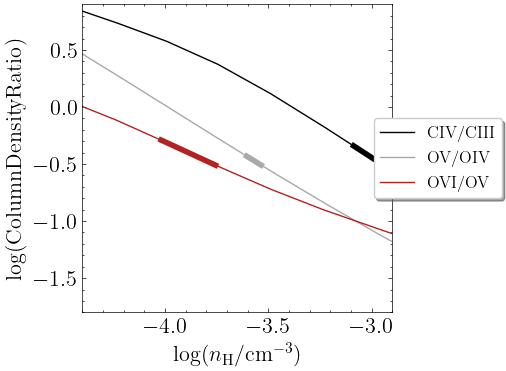

In [20]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, log_metals_ref=0.0)

ax.set_xlim(-4.4, -2.9)
ax.set_ylim(-1.8, .9)

(-1.8, 0.9)

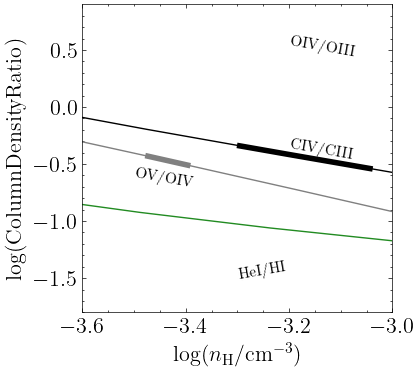

In [21]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict, label=False, log_metals_ref=-3.0,  colors=['black','grey','forestgreen','firebrick'])
ax.text(-3.2, -0.45, 'CIV/CIII', fontsize=11, rotation=-10)
ax.text(-3.3, -1.5, 'HeI/HI', fontsize=11, rotation=10)

ax.text(-3.5, -0.7, 'OV/OIV', fontsize=11, rotation=-10)
ax.text(-3.2, 0.45, 'OIV/OIII', fontsize=11, rotation=-10)

ax.set_xlim(-3.6, -3.0)
ax.set_ylim(-1.8, .9)

Text(0, 0.5, '$\\log(\\mathrm{Column \\ density \\ ratio})$')

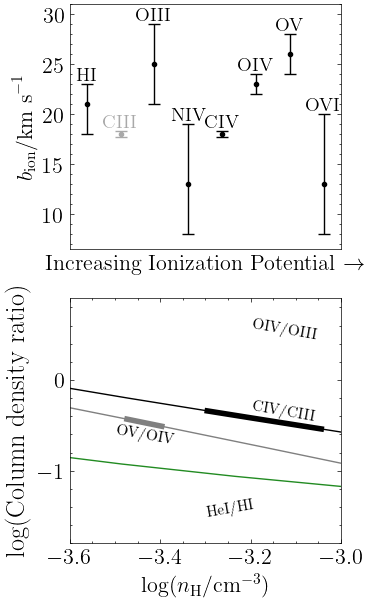

In [22]:
fig, axes = plt.subplots(2, 1, figsize=(3.5,3.5*2))

plot_linewidth_obs(b_dict, fig, axes[0], fs=14, gray_out=['CIII'])

axes[0].set_xlim(-0.5, len(b_dict)-1+0.5)
axes[0].set_ylim(6.5,31)

plot_logN_ratio(axes[1], species_logN_interp, logN_ratio_dict, label=False, log_metals_ref=-3.0,  colors=['black','grey','forestgreen','firebrick'])
axes[1].text(-3.2, -0.45, 'CIV/CIII', fontsize=11, rotation=-10)
axes[1].text(-3.3, -1.5, 'HeI/HI', fontsize=11, rotation=10)

axes[1].text(-3.5, -0.7, 'OV/OIV', fontsize=11, rotation=-10)
axes[1].text(-3.2, 0.45, 'OIV/OIII', fontsize=11, rotation=-10)

axes[1].set_xlim(-3.6, -3.0)
axes[1].set_ylim(-1.8, .9)
axes[1].set_ylabel(r'$\log(\mathrm{Column \ density \ ratio})$', fontsize=19)

#axes[1].legend(fontsize=11, loc='lower left')

#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_lw+frac.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

# Two-phase solution

In [23]:
def lambda_log_prior_two_phase(params, species_logN_interp):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'N': N_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    x = log_prior_two_phase(params_full, species_logN_interp)
    
    if np.isfinite(x):
        logN_OIV_p1 = species_logN_interp['O+3']([logN_HI_test, log_hdens_p1, log_metals_p1])[0]
        logN_OIV_p2 = species_logN_interp['O+3']([logN_HI_p2, log_hdens_p2, log_metals_p2])[0]
        if logN_OIV_p1<logN_OIV_p2:
            return x
        else:
            return -np.inf
    else:
        return -np.inf

In [24]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'N': N_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    # Call the original likelihood function on the full set of parameters    
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)  

    #x = log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    
    
    # Additional constraints from phase-wise measurements
    #logN_OIII_p1 = species_logN_interp['O+2']([logN_HI_test, log_hdens_p1, log_metals_p1])[0]
    #ll_OIII_p1 = -.5*(logN_OIII_p1-14.02)**2/0.07**2
    
    #logN_OIII_p2 = species_logN_interp['O+2']([logN_HI_p2, log_hdens_p2, log_metals_p2])[0]
    #ll_OIII_p2 = -.5*(logN_OIII_p2-13.9)**2/0.1**2

    #logN_CIV_p1 = species_logN_interp['C+3']([logN_HI_test, log_hdens_p1, log_metals_p1])[0]+C_O_p1
    #ll_CIV_p1 = -.5*(logN_CIV_p1-13.90)**2/0.05**2
    
    #logN_CIV_p2 = species_logN_interp['C+3']([logN_HI_p2, log_hdens_p2, log_metals_p2])[0]+C_O_p2
    #ll_CIV_p2 = -.5*(logN_CIV_p2-13.1)**2/0.3**2
    
    #return x+ll_OIII_p1+ll_OIII_p2+ll_CIV_p1+ll_CIV_p2

In [25]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params, species_logN_interp)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [26]:
logN_dict = {'HI':'14.5, -0.1, +0.2',
            'HeI':'<13.2',
            'CII':'<13.5',
            'CIII':'14.4, -0.1, +0.1',
            'CIV':'13.97, -0.01, +0.01',
            'NII':'<13.5',
            'NIV':'13.1, -0.1, +0.1',
            'NV':'<13.5',
            'OII':'<13.5',
            'OIII':'14.22, -0.05, +0.05',
            'OIV':'14.67, -0.02, +0.02',
            'OV':'14.20, -0.04, +0.04',
            'OVI':'13.8, -0.1, +0.1',
            'NeVI':'<13.8',
            #'NeVIII':'<13.8',
            'MgII':'<11.4',
            #'MgX':'<13.9',
            #'AlII':'<11.2',
            #'AlIII':'<11.6',
            'SiII':'<12.3',
            'SiIII':'<12.4',
            'SIV':'<13.0',
            'SV':'<12.7',
            'SVI':'<13.7',}
            #'FeII':'<11.8',}

In [27]:
logN_HI_test = 14.5
log_hdens_test_p1 = -3.0
log_metals_test_p1 = 0.0
C_O_test_p1 = 0.5
N_O_test_p1 = 0.0

logN_HI_test_p2 = 14.0
log_hdens_test_p2 = -3.75
log_metals_test_p2 = 0.2
C_O_test_p2 = -3.0
N_O_test_p2 = -3.0

In [28]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test, 
                                                 log_hdens_test_p1, 
                                                 log_metals_test_p1, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p1, 'N': N_O_test_p1}))

logN_species_test_p2 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test_p2, 
                                                 log_hdens_test_p2, 
                                                 log_metals_test_p2, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p2, 'N': N_O_test_p2}))

logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

(12.0, 15.0)

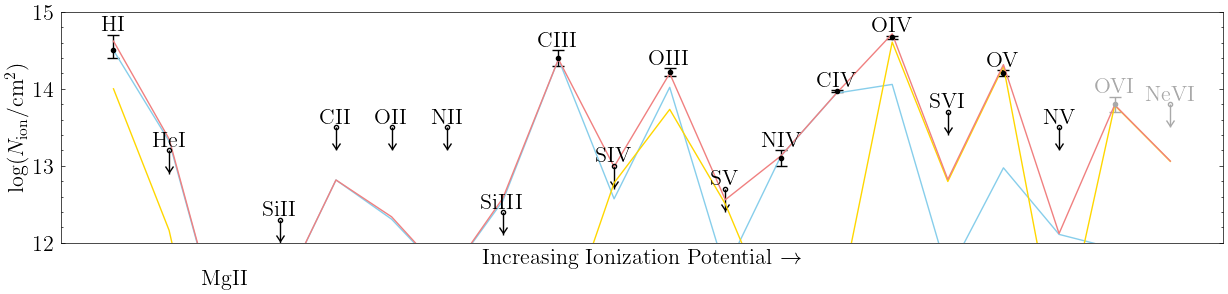

In [29]:
fig, ax = plt.subplots(1, figsize=(15,3.))

plot_column_densities_obs(logN_dict, fig, ax,
                          gray_out = ['OVI', 'NeVI', 'NeVIII'])

#ax.errorbar(9, 14.02, xerr=None, yerr=[[0.04],[0.07]], color='dodgerblue', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')
#ax.errorbar(9, 13.9, xerr=None, yerr=0.1, color='firebrick', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')

#ax.errorbar(12, 13.90, xerr=None, yerr=0.05, color='dodgerblue', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')
#ax.errorbar(12, 13.1, xerr=None, yerr=[[0.3],[0.2]], color='firebrick', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')

ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

ax.set_ylim(12,15)

In [30]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, C_O_test_p1, N_O_test_p1,
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2, N_O_test_p2]) + 1e-4 * np.random.randn(200, 9)
nwalkers, ndim = pos.shape

In [31]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [32]:
sampler.run_mcmc(pos, 1000, progress=True);

100%|███████████████████████████████████████| 1000/1000 [09:39<00:00,  1.73it/s]


In [33]:
flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens_p1', 'log_metals_p1', 'C_O_p1', 'N_O_p1', 
                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2', 'N_O_p2'])
flat_samples_two_phase.to_csv(savedir+'two_phase.csv', index=False)

#flat_samples_two_phase = pd.read_csv(savedir+'two_phase.csv')

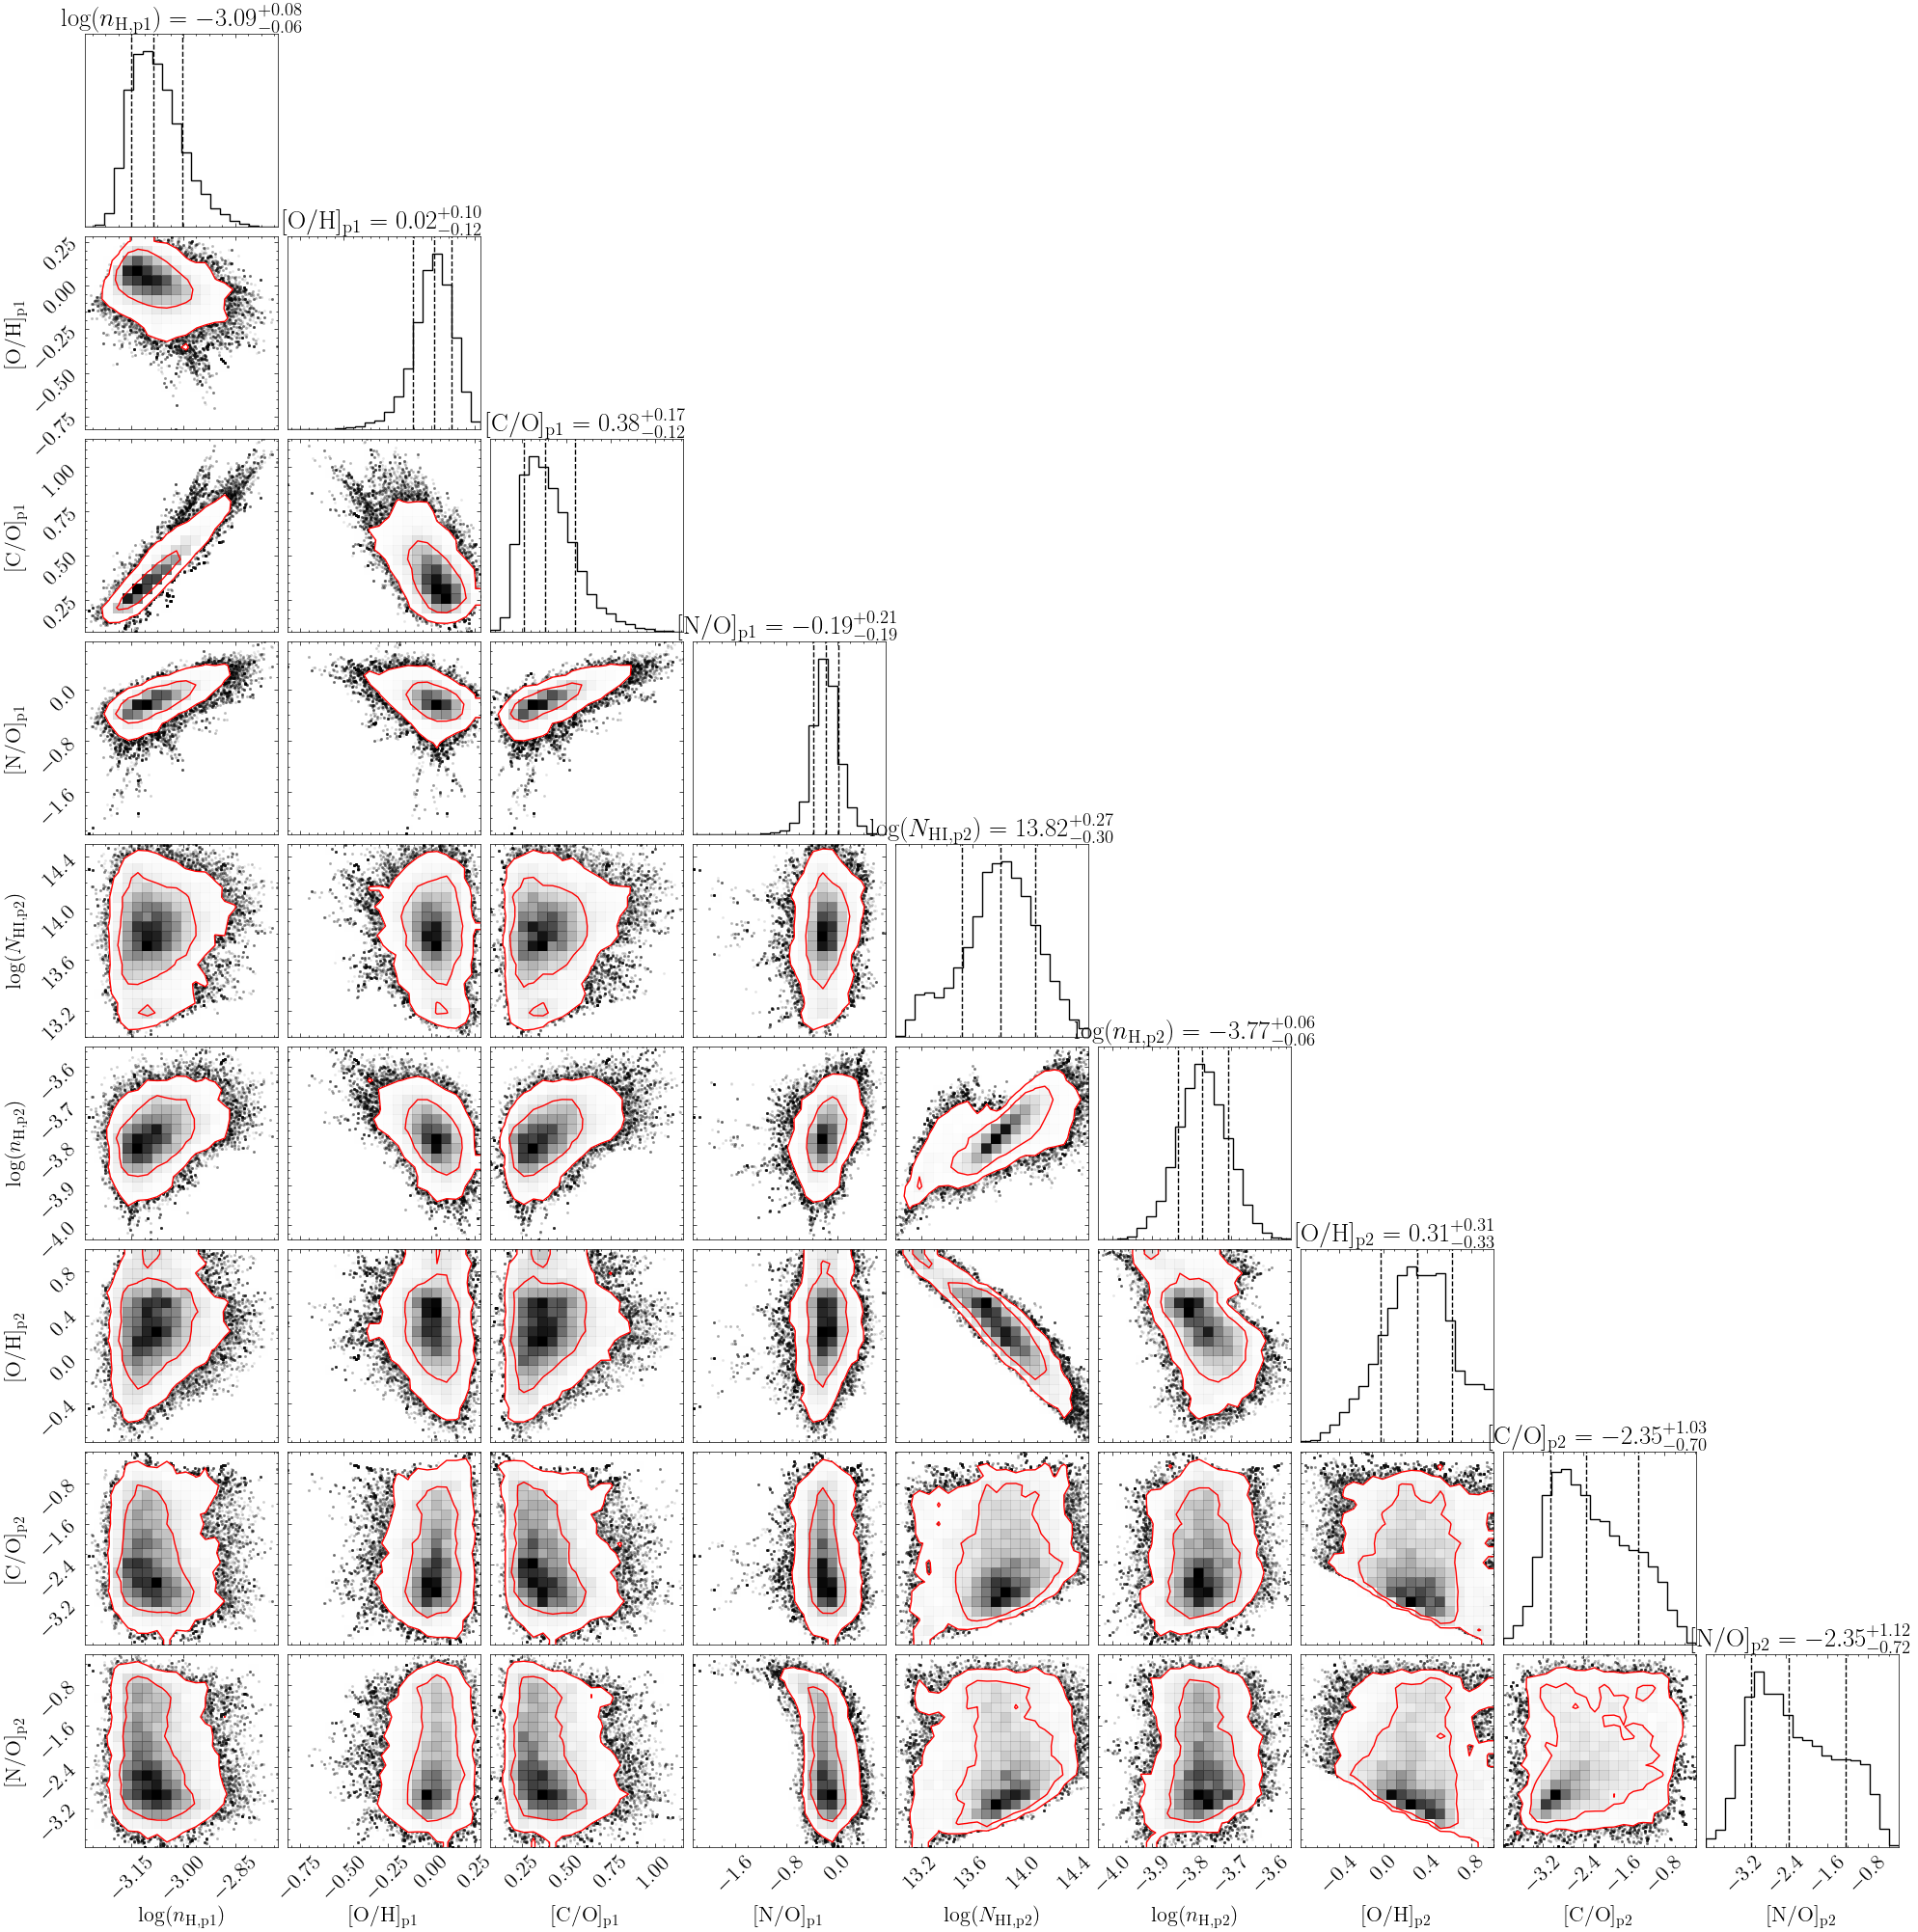

In [34]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$', r'$[\mathrm{C/O}]_{\mathrm{p1}}$', r'$[\mathrm{N/O}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$', r'$[\mathrm{C/O}]_{\mathrm{p2}}$', r'$[\mathrm{N/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [35]:
np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['logN_HI_p2'], 100*cdf_3sig)

(13.087229381318547, 14.477766985130003)

In [36]:
np.percentile(flat_samples_two_phase['log_metals_p2'], 100*(1-cdf_3sig)), np.percentile(flat_samples_two_phase['log_metals_p2'], 100*cdf_3sig)

(-0.5828027647271847, 0.9954141508146359)

In [37]:
np.percentile(flat_samples_two_phase['C_O_p2'], 100*cdf_3sig), np.percentile(flat_samples_two_phase['N_O_p2'], 100*cdf_3sig)

(-0.38209790559214074, -0.3911145056582148)

Now plot the best models

In [38]:
logN_dict = {#'HI':'14.5, -0.1, +0.2',
            'HeI':'<13.2',
            #'CII':'<13.5',
            'CIII':'14.4, -0.1, +0.1',
            'CIV':'13.97, -0.01, +0.01',
            #'NII':'<13.5',
            'NIV':'13.1, -0.1, +0.1',
            #'NV':'<13.5',
            #'OII':'<13.5',
            'OIII':'14.22, -0.05, +0.05',
            'OIV':'14.67, -0.02, +0.02',
            'OV':'14.20, -0.04, +0.04',
            'OVI':'13.8, -0.1, +0.1',
            #'NeVI':'<13.8',
            #'NeVIII':'<13.8',
            #'MgII':'<11.4',
            #'MgX':'<13.9',
            #'AlII':'<11.2',
            #'AlIII':'<11.6',
            #'SiII':'<12.3',
            'SiIII':'<12.4',
            'SIV':'<13.0',
            'SV':'<12.7',
            'SVI':'<13.7',}
            #'FeII':'<11.8',}

In [39]:
import matplotlib.lines as mlines

In [40]:
# Best-fit model prediction

logN_species_p1_best = predict_col_dens(logN_dict, logN_HI_test, np.median(flat_samples_two_phase['log_hdens_p1']), 
                                        np.median(flat_samples_two_phase['log_metals_p1']), 
                                        species_logN_interp, {'C':np.median(flat_samples_two_phase['C_O_p1']), 
                                                              'N':np.median(flat_samples_two_phase['N_O_p1'])})

logN_species_p2_best = predict_col_dens(logN_dict, np.median(flat_samples_two_phase['logN_HI_p2']), 
                                        np.median(flat_samples_two_phase['log_hdens_p2']), 
                                        np.median(flat_samples_two_phase['log_metals_p2']), 
                                                 species_logN_interp, {'C':np.median(flat_samples_two_phase['C_O_p2']), 'N':np.median(flat_samples_two_phase['N_O_p2'])})

logN_species_best = np.log10(10**logN_species_p1_best + 10**logN_species_p2_best)

In [41]:
logN_res_dict = get_logN_residuals(logN_dict, logN_species_best)

In [42]:
logN_res_up = {k:'<0.9' for k in list(logN_res_dict.keys())}

#logN_res_up['SiII'] = '<0.5'
#logN_res_up['OII'] = '<0.5'
#logN_res_up['NV'] = '<0.5'
logN_res_up['SVI'] = '<0.5'

In [43]:
# Model curves for each step
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

In [44]:
# Draws within 1-sigma of well-constrained values

filtered = []

log_hdens_p1_lo = np.percentile(flat_samples_two_phase['log_hdens_p1'], 100*(1-cdf_1sig))
log_hdens_p1_hi = np.percentile(flat_samples_two_phase['log_hdens_p1'], 100*cdf_1sig)

log_metals_p1_lo = np.percentile(flat_samples_two_phase['log_metals_p1'], 100*(1-cdf_1sig))
log_metals_p1_hi = np.percentile(flat_samples_two_phase['log_metals_p1'], 100*cdf_1sig)

C_O_p1_lo = np.percentile(flat_samples_two_phase['C_O_p1'], 100*(1-cdf_1sig))
C_O_p1_hi = np.percentile(flat_samples_two_phase['C_O_p1'], 100*cdf_1sig)

N_O_p1_lo = np.percentile(flat_samples_two_phase['N_O_p1'], 100*(1-cdf_1sig))
N_O_p1_hi = np.percentile(flat_samples_two_phase['N_O_p1'], 100*cdf_1sig)

log_hdens_p2_lo = np.percentile(flat_samples_two_phase['log_hdens_p2'], 100*(1-cdf_1sig))
log_hdens_p2_hi = np.percentile(flat_samples_two_phase['log_hdens_p2'], 100*cdf_1sig)

for i in range(len(flat_samples_two_phase)):
    log_hdens_p1 = flat_samples_two_phase['log_hdens_p1'][i]
    log_metals_p1 = flat_samples_two_phase['log_metals_p1'][i]
    C_O_p1 = flat_samples_two_phase['C_O_p1'][i]
    N_O_p1 = flat_samples_two_phase['N_O_p1'][i]
    log_hdens_p2 = flat_samples_two_phase['log_hdens_p2'][i]
    
    if log_hdens_p1_lo<log_hdens_p1<log_hdens_p1_hi and log_metals_p1_lo<log_metals_p1<log_metals_p1_hi and C_O_p1_lo<C_O_p1<C_O_p1_hi and N_O_p1_lo<N_O_p1<N_O_p1_hi and log_hdens_p2_lo<log_hdens_p2<log_hdens_p2_hi:
        filtered.append(i)
        
plot_idx = np.random.randint(0, len(filtered), 50)

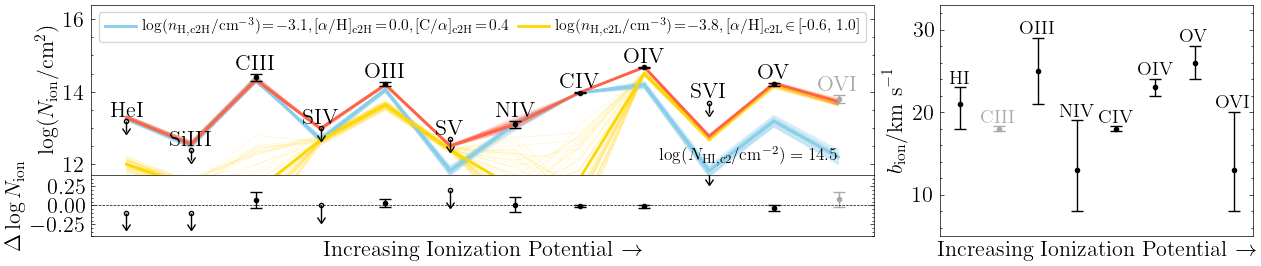

In [45]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

for idx in plot_idx:
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_grid[:,filtered[idx]], color='skyblue', lw=.5, alpha=.2)
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_grid[:,filtered[idx]], color='gold', lw=.5, alpha=.2)
    axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_grid[:,filtered[idx]], color='tomato', lw=.5, alpha=.2)
    
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_best, color='skyblue', lw=2)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_best, color='gold', lw=2)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_best, color='tomato', lw=2)


plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['OVI', 'NeVI', 'NeVIII'])

axd['upper left'].set_ylim(11.7,16.4)

axd['upper left'].set_xlabel(None)

axd['upper left'].text(len(logN_dict)-1, 12.1, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 14.5$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2H}/\mathrm{cm}^{-3}) \!=\! -3.1, \mathrm{[\alpha/H]_{c2H}}\!=\! 0.0, \mathrm{[C/\alpha]_{c2H}}\!=\!0.4$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2L}/\mathrm{cm}^{-3}) \!=\! -3.8, \mathrm{[\alpha/H]_{c2L}}\!\in\!$ [-0.6, 1.0]'))
    
axd['upper left'].legend(handles=handles, loc='upper left', fontsize=11.1, ncol=2, columnspacing=.6, handletextpad=0.4)

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], gray_out = ['OVI'], label_ions=False, dy=.15)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], gray_out = ['OVI'], label_ions=False, dy=.15)

axd['lower left'].set_ylim(-.4,.4)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')


plot_linewidth_obs(b_dict, fig, axd['right'], fs=14, gray_out=['CIII'])
axd['right'].set_xlim(-0.5, len(b_dict)-1+0.5)
axd['right'].set_ylim(5,33)

plt.subplots_adjust(wspace=0.12, hspace=0)  

plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)
plt.savefig('/Users/thepoetoftwilight/Documents/Astro/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

Get cloud sizes

In [46]:
l_p1 = get_cloud_size(logN_HI_test, flat_samples_two_phase['log_hdens_p1'], species_logN_interp, flat_samples_two_phase['log_metals_p1'])
l_p2 = get_cloud_size(flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], species_logN_interp, flat_samples_two_phase['log_metals_p2'])

Text(0, 0.5, 'Counts')

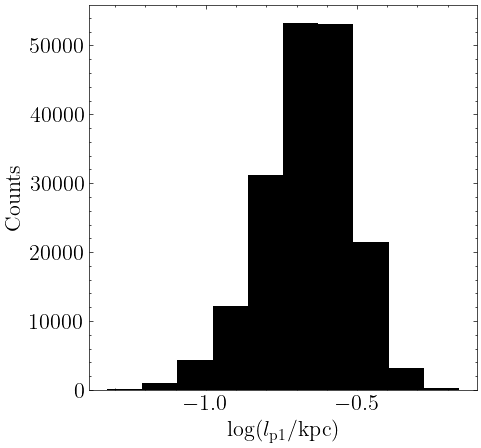

In [47]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p1), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p1}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [48]:
get_quantiles(np.log10(l_p1))

-0.65 -0.16 0.13


In [49]:
np.median(np.log10(l_p1))

-0.6518180366945013

In [50]:
np.percentile(np.log10(l_p1), 100*cdf_1sig)-np.median(np.log10(l_p1))

0.1291192440388913

Text(0, 0.5, 'Counts')

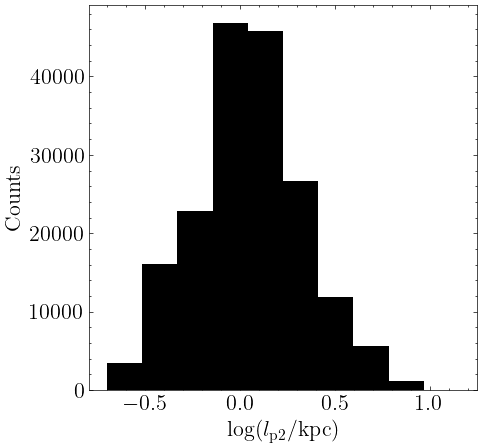

In [51]:
fig, ax = plt.subplots(1, figsize=(5,5))

ax.hist(np.log10(l_p2), bins=10)

ax.set_xlabel(r'$\log(l_{\mathrm{p2}}/\mathrm{kpc})$')
ax.set_ylabel('Counts')

In [52]:
get_quantiles(np.log10(l_p2))

0.04 -0.28 0.28


In [53]:
np.percentile(np.log10(l_p2), 100*(1-cdf_3sig)), np.percentile(np.log10(l_p2), 100*cdf_3sig)

(-0.6243642572093889, 0.8815286132938779)

# Two-phase from VP

## c1 (cooler)

In [142]:
logN_dict_c1 = {'HI':'14.5, -0.1, +0.1',
               'CIV':'13.8, -0.1, +0.1',
               'OIII':'13.5, -0.4, +0.3',
               'OIV':'14.0, -0.3, +0.3',
               'OV':'13.3, -0.5, +0.4'}

In [143]:
gen_logN_ratio_str(logN_dict_c2['OIV'], logN_dict_c2['OIII'])

'0.30, -0.14, 0.14'

In [144]:
logN_ratio_dict_c1 = {
                   'OV/OIV': '-0.70, -0.58, 0.50',
                   'OIV/OIII': '0.50, -0.50, 0.42',
                  }

(-2.0, 2.0)

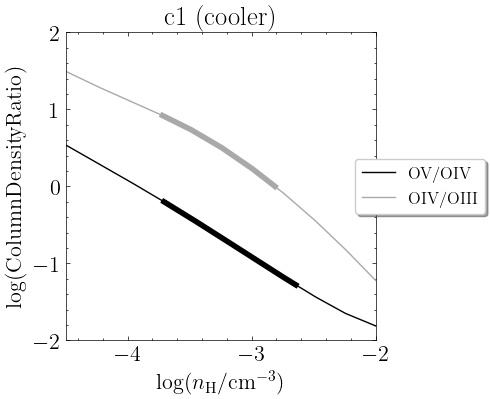

In [145]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict_c1)

ax.set_title('c1 (cooler)')
ax.set_xlim(-4.5, -2.0)
ax.set_ylim(-2, 2)

In [174]:
logN_HI_test = 14.5
log_hdens_test = -3.2
log_metals_test = -0.6
C_O_test = 0.5
N_O_test = 0.0

In [175]:
logN_dict_c1 = {#'HI':'14.5, -0.1, +0.1',
               'CIV':'13.8, -0.1, +0.1',
               'OIII':'13.5, -0.4, +0.3',
               'OIV':'14.0, -0.3, +0.3',
               'OV':'13.3, -0.5, +0.4'}

In [176]:
logN_species_test = np.array(predict_col_dens(logN_dict_c1, 
                                                 logN_HI_test, 
                                                 log_hdens_test, 
                                                 log_metals_test, 
                                                 species_logN_interp,
                                                 {'C': C_O_test, 'N': N_O_test}))

(12.0, 15.0)

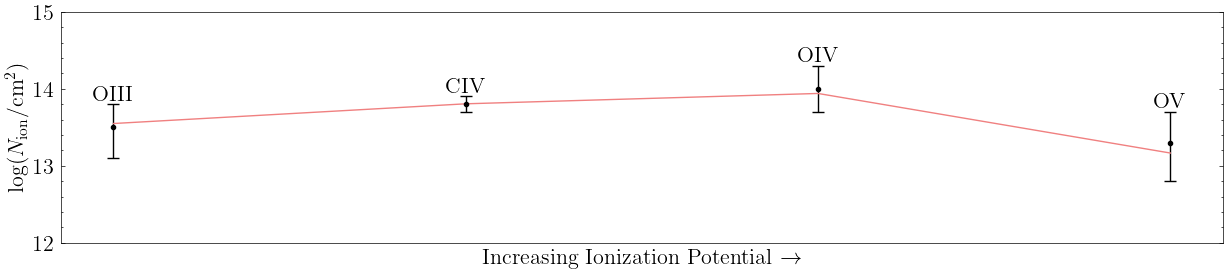

In [177]:
fig, ax = plt.subplots(1, figsize=(15,3.))

plot_column_densities_obs(logN_dict_c1, fig, ax,
                          gray_out = ['OVI', 'NeVI', 'NeVIII'])

#ax.errorbar(9, 14.02, xerr=None, yerr=[[0.04],[0.07]], color='dodgerblue', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')
#ax.errorbar(9, 13.9, xerr=None, yerr=0.1, color='firebrick', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')

#ax.errorbar(12, 13.90, xerr=None, yerr=0.05, color='dodgerblue', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')
#ax.errorbar(12, 13.1, xerr=None, yerr=[[0.3],[0.2]], color='firebrick', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')

ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

ax.set_ylim(12,15)

## c2 (warmer)

In [146]:
logN_dict_c2 = {'HI':'<14.4',
               'CIV':'13.6, -0.2, +0.2',
               'OIII':'14.2, -0.1, +0.1',
               'OIV':'14.5, -0.1, +0.1',
               'OV':'14.1, -0.1, +0.1'}

In [147]:
gen_logN_ratio_str(logN_dict_c2['OIV'], logN_dict_c2['OIII'])

'0.30, -0.14, 0.14'

In [148]:
logN_ratio_dict_c2 = {
                   'OV/OIV': '-0.40, -0.14, 0.14',
                   'OIV/OIII': '0.30, -0.14, 0.14',
                  }

(-2.0, 2.0)

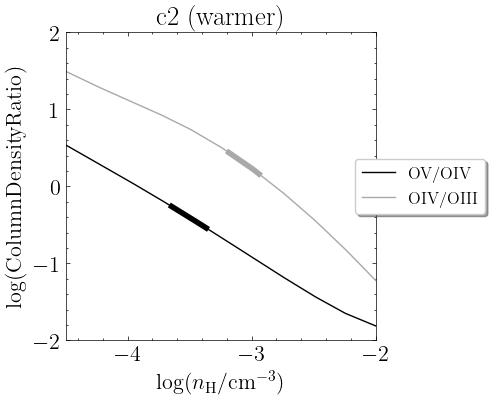

In [149]:
fig, ax = plt.subplots(1, figsize=(4,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict_c2)

ax.set_title('c2 (warmer)')
ax.set_xlim(-4.5, -2.0)
ax.set_ylim(-2, 2)

In [239]:
logN_HI_test = 13.6
log_hdens_test = -3.7
log_metals_test = 0.65
C_O_test = -0.3
N_O_test = 0.0

In [240]:
logN_dict_c2 = {#'HI':'<14.4',
               'CIV':'13.6, -0.2, +0.2',
               'OIII':'14.2, -0.1, +0.1',
               'OIV':'14.5, -0.1, +0.1',
               'OV':'14.1, -0.1, +0.1'}

In [241]:
logN_species_test = np.array(predict_col_dens(logN_dict_c2, 
                                                 logN_HI_test, 
                                                 log_hdens_test, 
                                                 log_metals_test, 
                                                 species_logN_interp,
                                                 {'C': C_O_test, 'N': N_O_test}))

(12.0, 15.0)

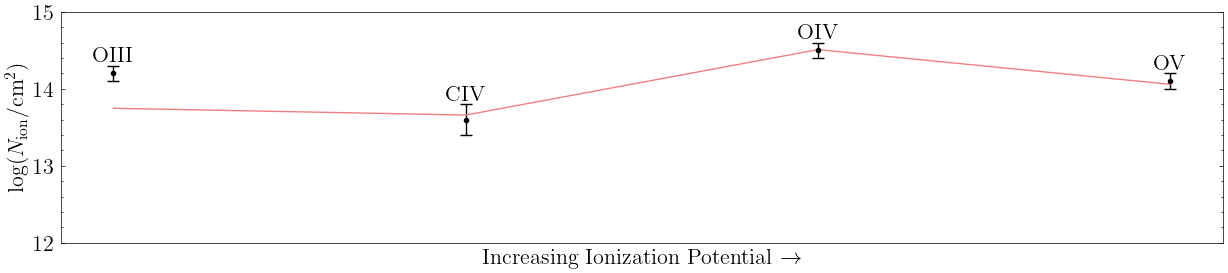

In [242]:
fig, ax = plt.subplots(1, figsize=(15,3.))

plot_column_densities_obs(logN_dict_c2, fig, ax,
                          gray_out = ['OVI', 'NeVI', 'NeVIII'])

#ax.errorbar(9, 14.02, xerr=None, yerr=[[0.04],[0.07]], color='dodgerblue', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')
#ax.errorbar(9, 13.9, xerr=None, yerr=0.1, color='firebrick', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')

#ax.errorbar(12, 13.90, xerr=None, yerr=0.05, color='dodgerblue', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')
#ax.errorbar(12, 13.1, xerr=None, yerr=[[0.3],[0.2]], color='firebrick', linestyle='none', capsize=4, marker='o', markersize=3,
#           markerfacecolor='none')

ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

ax.set_ylim(12,15)

# Two-phase solution revisited

In [59]:
def lambda_log_prior_two_phase(params, species_logN_interp):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'N': N_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    x = log_prior_two_phase(params_full, species_logN_interp)
    
    if np.isfinite(x):
        logN_OIV_p1 = species_logN_interp['O+3']([logN_HI_test, log_hdens_p1, log_metals_p1])[0]
        logN_OIV_p2 = species_logN_interp['O+3']([logN_HI_p2, log_hdens_p2, log_metals_p2])[0]
        if logN_OIV_p1<logN_OIV_p2:
            return x
        else:
            return -np.inf
    else:
        return -np.inf

In [60]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O_p1, N_O_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C': C_O_p1, 'N': N_O_p1},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    # Call the original likelihood function on the full set of parameters    

    x = log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    
    
    # Additional constraints from phase-wise measurements
    logN_OIII_p1 = species_logN_interp['O+2']([logN_HI_test, log_hdens_p1, log_metals_p1])[0]
    ll_OIII_p1 = -.5*(logN_OIII_p1-14.02)**2/0.07**2
    
    logN_OIII_p2 = species_logN_interp['O+2']([logN_HI_p2, log_hdens_p2, log_metals_p2])[0]
    ll_OIII_p2 = -.5*(logN_OIII_p2-13.9)**2/0.1**2

    logN_CIV_p1 = species_logN_interp['C+3']([logN_HI_test, log_hdens_p1, log_metals_p1])[0]+C_O_p1
    ll_CIV_p1 = -.5*(logN_CIV_p1-13.90)**2/0.05**2
    
    logN_CIV_p2 = species_logN_interp['C+3']([logN_HI_p2, log_hdens_p2, log_metals_p2])[0]+C_O_p2
    ll_CIV_p2 = -.5*(logN_CIV_p2-13.1)**2/0.3**2
    
    return x+ll_OIII_p1+ll_OIII_p2+ll_CIV_p1+ll_CIV_p2

In [61]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params, species_logN_interp)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [66]:
logN_dict = {'HI':'14.5, -0.1, +0.2',
    'HeI':'<13.1',
    'CII':'<13.5',
    'CIII':'14.4, -0.1, +0.1',
    'CIV':'13.97, -0.01, +0.01',
    'NII':'<13.5',
    'NIV':'13.1, -0.1, +0.1',
    'NV':'<13.5',
    'OII':'<13.5',
    'OIII':'14.27, -0.02, +0.02',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.04, +0.04',
    'OVI':'<13.8',
    'NeVI':'<13.8',
    #'NeVIII':'<13.8',
    'MgII':'<11.4',
    #'MgX':'<13.9',
    #'AlII':'<11.2',
    #'AlIII':'<11.6',
    'SiII':'<12.3',
    'SiIII':'<12.2',
    'SIV':'<12.8',
    'SV':'<12.4',
    'SVI':'<13.7',}
    #'FeII':'<11.8'}

In [98]:
logN_HI_test = 14.5
log_hdens_test_p1 = -3.0
log_metals_test_p1 = 0.0
C_O_test_p1 = 0.5
N_O_test_p1 = 0.0

logN_HI_test_p2 = 14.1
log_hdens_test_p2 = -3.65
log_metals_test_p2 = 0.2
C_O_test_p2 = -1.2
N_O_test_p2 = -3.0

In [99]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test, 
                                                 log_hdens_test_p1, 
                                                 log_metals_test_p1, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p1, 'N': N_O_test_p1}))

logN_species_test_p2 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test_p2, 
                                                 log_hdens_test_p2, 
                                                 log_metals_test_p2, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p2, 'N': N_O_test_p2}))

logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

(12.0, 15.0)

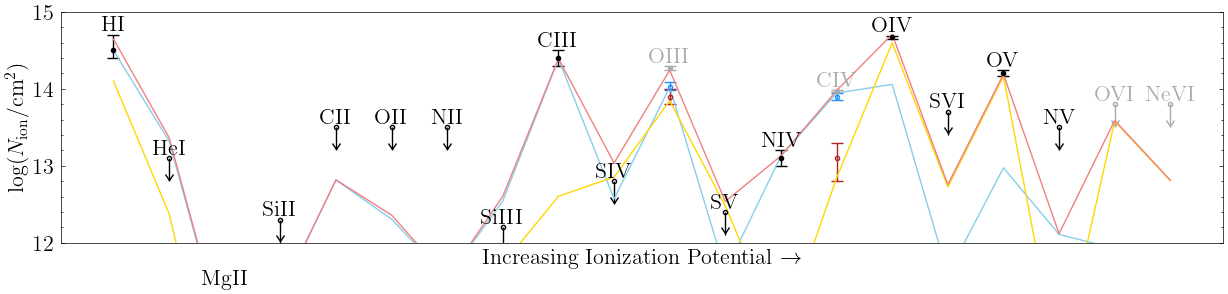

In [100]:
fig, ax = plt.subplots(1, figsize=(15,3.))

plot_column_densities_obs(logN_dict, fig, ax,
                          gray_out = ['OIII','CIV','OVI', 'NeVI', 'NeVIII'])

ax.errorbar(10, 14.02, xerr=None, yerr=[[0.04],[0.07]], color='dodgerblue', linestyle='none', capsize=4, marker='o', markersize=3,
           markerfacecolor='none')
ax.errorbar(10, 13.9, xerr=None, yerr=0.1, color='firebrick', linestyle='none', capsize=4, marker='o', markersize=3,
           markerfacecolor='none')

ax.errorbar(13, 13.90, xerr=None, yerr=0.05, color='dodgerblue', linestyle='none', capsize=4, marker='o', markersize=3,
           markerfacecolor='none')
ax.errorbar(13, 13.1, xerr=None, yerr=[[0.3],[0.2]], color='firebrick', linestyle='none', capsize=4, marker='o', markersize=3,
           markerfacecolor='none')

ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='skyblue')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='gold')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

ax.set_ylim(12,15)

In [58]:
logN_dict_c2H = {
    'HI':'14.5, -0.1, +0.2',
    'HeI':'<13.0',
    #'CII':'<13.5',
    'CIII':'14.4, -0.1, +0.2',
    'CIV':'13.97, -0.01, +0.01',
    #'NII':'<13.4',
    'NIV':'13.1, -0.1, +0.1',
    #'NV':'<13.6',
    #'OII':'<13.4',
    'OIII':'14.27, -0.02, +0.02',
    #'OIV':'14.67, -0.02, +0.02',
    #'OV':'14.20, -0.04, +0.04',
    #'OVI':'13.8, -0.1, +0.1',
    #'NeVI':'<13.8',
    #'NeVIII':'<13.8',
    #'MgII':'<11.3',
    #'MgX':'<13.9',
    #'AlII':'<11.2',
    #'AlIII':'<11.5',
    #'SiII':'<12.3',
    'SiIII':'<12.1',
    'SIV':'<12.8',
    'SV':'<12.3',}
    #'SVI':'<13.7',}
    #'FeII':'<11.7',}
    
logN_dict_c2L = {
    #'HI':'14.5, -0.1, +0.2',
    #'HeI':'<13.0',
    #'CII':'<13.5',
    #'CIII':'14.4, -0.1, +0.2',
    'CIV':'13.97, -0.01, +0.01',
    #'NII':'<13.4',
    'NIV':'13.1, -0.1, +0.1',
    #'NV':'<13.6',
    #'OII':'<13.4',
    'OIII':'14.27, -0.02, +0.02',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.04, +0.04',
    'OVI':'13.8, -0.1, +0.1',
    #'NeVI':'<13.8',
    #'NeVIII':'<13.8',
    #'MgII':'<11.3',
    #'MgX':'<13.9',
    #'AlII':'<11.2',
    #'AlIII':'<11.5',
    #'SiII':'<12.3',
    #'SiIII':'<12.1',
    #'SIV':'<12.8',
    'SV':'<12.3',}
    #'SVI':'<13.7',}
    #'FeII':'<11.7',}

In [412]:
# c2H
logN_species_p1_grid = predict_col_dens(logN_dict_c2H, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict_c2H, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

# Medians and errorbars for plotting
logN_species_p1_med_c2H = np.median(logN_species_p1_grid, axis=1)
logN_species_p1_lo_c2H = np.percentile(logN_species_p1_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p1_hi_c2H = np.percentile(logN_species_p1_grid, 100*cdf_1sig, axis=1)

logN_species_p2_med_c2H = np.median(logN_species_p2_grid, axis=1)
logN_species_p2_lo_c2H = np.percentile(logN_species_p2_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p2_hi_c2H = np.percentile(logN_species_p2_grid, 100*cdf_1sig, axis=1)

logN_species_med_c2H = np.median(logN_species_grid, axis=1)
logN_species_lo_c2H = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi_c2H = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

# c2L
logN_species_p1_grid = predict_col_dens(logN_dict_c2L, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict_c2L, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

# Medians and errorbars for plotting
logN_species_p1_med_c2L = np.median(logN_species_p1_grid, axis=1)
logN_species_p1_lo_c2L = np.percentile(logN_species_p1_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p1_hi_c2L = np.percentile(logN_species_p1_grid, 100*cdf_1sig, axis=1)

logN_species_p2_med_c2L = np.median(logN_species_p2_grid, axis=1)
logN_species_p2_lo_c2L = np.percentile(logN_species_p2_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p2_hi_c2L = np.percentile(logN_species_p2_grid, 100*cdf_1sig, axis=1)

logN_species_med_c2L = np.median(logN_species_grid, axis=1)
logN_species_lo_c2L = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi_c2L = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

In [415]:
logN_res_dict_c2H = get_logN_residuals(logN_dict_c2H, logN_species_med_c2H, logN_species_lo_c2H, logN_species_hi_c2H)
logN_res_dict_c2L = get_logN_residuals(logN_dict_c2L, logN_species_med_c2L, logN_species_lo_c2L, logN_species_hi_c2L)

Text(0, 0.5, '')

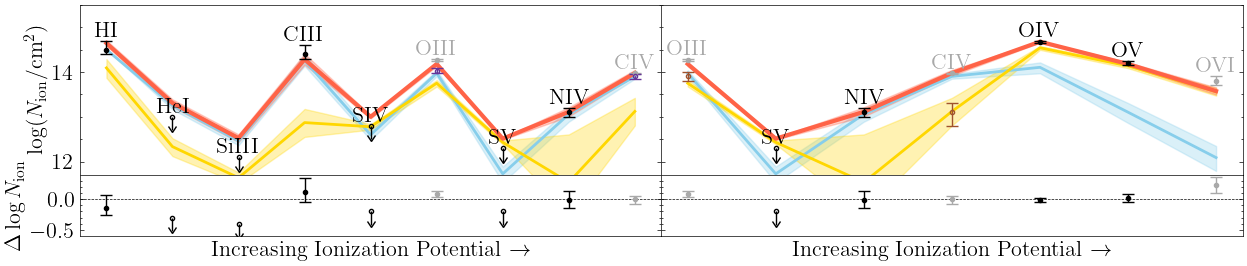

In [426]:
fig, axes = plt.subplots(2, 2, figsize=(15,3.), gridspec_kw={'height_ratios': [2.8, 1]}, sharey='row')

axes[0,0].fill_between(np.arange(len(logN_dict_c2H)), logN_species_p1_lo_c2H, logN_species_p1_hi_c2H,
                color='skyblue', alpha=.3)
axes[0,0].plot(np.arange(len(logN_dict_c2H)), logN_species_p1_med_c2H, color='skyblue', lw=2, alpha=1)

axes[0,0].fill_between(np.arange(len(logN_dict_c2H)), logN_species_p2_lo_c2H, logN_species_p2_hi_c2H,
                color='gold', alpha=.3)
axes[0,0].plot(np.arange(len(logN_dict_c2H)), logN_species_p2_med_c2H, color='gold', lw=2, alpha=1)

axes[0,0].fill_between(np.arange(len(logN_dict_c2H)), logN_species_lo_c2H, logN_species_hi_c2H,
                color='tomato', alpha=.3)
axes[0,0].plot(np.arange(len(logN_dict_c2H)), logN_species_med_c2H, color='tomato', lw=3, alpha=1)

plot_column_densities_obs(logN_dict_c2H, fig, axes[0,0],
                          gray_out = ['OIII','CIV','OVI', 'NeVI', 'NeVIII'])

axes[0,0].set_ylim(11.7,15.5)

axes[0,0].set_xlabel(None)

#axes[0,0].text(len(logN_dict_c2H)-1, 12.2, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 14.5_{-0.1}^{+0.2}$', fontsize=12,
#            horizontalalignment='right')


axes[0,1].fill_between(np.arange(len(logN_dict_c2L)), logN_species_p1_lo_c2L, logN_species_p1_hi_c2L,
                color='skyblue', alpha=.3)
axes[0,1].plot(np.arange(len(logN_dict_c2L)), logN_species_p1_med_c2L, color='skyblue', lw=2, alpha=1)

axes[0,1].fill_between(np.arange(len(logN_dict_c2L)), logN_species_p2_lo_c2L, logN_species_p2_hi_c2L,
                color='gold', alpha=.3)
axes[0,1].plot(np.arange(len(logN_dict_c2L)), logN_species_p2_med_c2L, color='gold', lw=2, alpha=1)

axes[0,1].fill_between(np.arange(len(logN_dict_c2L)), logN_species_lo_c2L, logN_species_hi_c2L,
                color='tomato', alpha=.3)
axes[0,1].plot(np.arange(len(logN_dict_c2L)), logN_species_med_c2L, color='tomato', lw=3, alpha=1)

plot_column_densities_obs(logN_dict_c2L, fig, axes[0,1],
                          gray_out = ['OIII','CIV','OVI', 'NeVI', 'NeVIII'])

axes[0,1].set_ylim(11.7,15.5)

axes[0,1].set_ylabel(None)
axes[0,1].set_xlabel(None)

# Phase-wise measurements
axes[0,0].errorbar(5, 14.02, xerr=None, yerr=[[0.04],[0.07]], color='rebeccapurple', linestyle='none', capsize=4, marker='o', markersize=3,
           markerfacecolor='none')
axes[0,1].errorbar(0, 13.9, xerr=None, yerr=0.1, color='sienna', linestyle='none', capsize=4, marker='o', markersize=3,
           markerfacecolor='none')

axes[0,0].errorbar(8, 13.90, xerr=None, yerr=0.05, color='rebeccapurple', linestyle='none', capsize=4, marker='o', markersize=3,
           markerfacecolor='none')
axes[0,1].errorbar(3, 13.1, xerr=None, yerr=[[0.3],[0.2]], color='sienna', linestyle='none', capsize=4, marker='o', markersize=3,
           markerfacecolor='none')

plt.subplots_adjust(wspace=0, hspace=0)

plot_column_densities_obs(logN_res_dict_c2H, fig, axes[1,0], gray_out = ['OIII','CIV','OVI'], label_ions=False, dy=.15)
axes[1,0].set_ylim(-.6,.4)
axes[1,0].axhline(0, linestyle='--', lw=.5)
axes[1,0].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

plot_column_densities_obs(logN_res_dict_c2L, fig, axes[1,1], gray_out = ['OIII','CIV','OVI'], label_ions=False, dy=.15)
axes[1,1].set_ylim(-.6,.4)
axes[1,1].axhline(0, linestyle='--', lw=.5)
axes[1,1].set_ylabel(r'')

# DRAFT

# Single phase solution

In [50]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<12.8',
    #'CII':'<13.2',
    'CIII':'>13.8',
    'CIV':'13.96, -0.01, +0.01',
    #'NII':'<13.2',
    #'NIV':'13.0, -0.1, +0.1',
    #'NV':'<13.2',
    'OII':'<13.2',
    'OIII':'14.29, -0.02, +0.02',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.05, +0.05',#'OV':'<14.20',
    'OVI':'<13.8',
    'NeVI':'<13.5',
    'NeVIII':'<13.5',
    'MgII':'<11.1',
    'MgX':'<13.6',}
    #'AlII':'<11.0',
    #'AlIII':'<11.3',
    #'SiII':'<12.1',
    #'SiIII':'<11.9',
    #'SIV':'<12.6',
    #'SV':'<12.1',
    #'SVI':'<13.4',
    #'FeII':'<11.6',}

Get column density ratios

In [51]:
gen_logN_ratio_str(logN_dict['CIII'], logN_dict['CIV'])

'>-0.16, 0.33'

In [52]:
logN_ratio_dict = {#'OII/OIII': '<-1.1, 0.1',
                   #'CIII/CIV': '>-0.1, 0.3',
                   'OIV/OIII': '0.38, -0.03, 0.03',
                   'OV/OIV': '-0.47, -0.05, 0.05'
                   #'OV/OIV': '<-0.47, 0.1',
                   #'OVI/OIV': '<-0.9, 0.1'
                   }

Generate predicted column density ratios

(-2.0, 1.0)

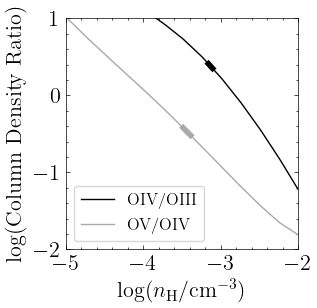

In [53]:
fig, ax = plt.subplots(1, figsize=(3,3))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)
ax.set_ylabel('log(Column Density Ratio)')
#ax.axhline(0.28, linestyle=':')
ax.legend()
ax.set_xlim(-5, -2)
ax.set_ylim(-2, 1)

#plt.savefig(savedir+'logN_ratio.pdf', dpi=300)

Fit gas density

In [54]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [55]:
logN_ratio_dict

{'OIV/OIII': '0.38, -0.03, 0.03', 'OV/OIV': '-0.47, -0.05, 0.05'}

In [56]:
pos = np.array(-3.15) + 1e-4 * np.random.randn(200, 1)
nwalkers, ndim = pos.shape

In [57]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
)

In [58]:
#sampler.run_mcmc(pos, 500, progress=True);

In [59]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_op.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_op.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z=1.09456549/cloudy_fits/hdens_op.csv'

In [ ]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [ ]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [ ]:
logN_offset = 14.29-np.mean(species_logN_interp['O+2'](grid_points_hdens))

Calculate the C/O ratio

In [ ]:
logN_CIV_obs = np.random.normal(loc=13.96, scale=0.01, size=len(flat_samples_hdens))

In [ ]:
C_O_dist_CIV = logN_CIV_obs-(logN_offset+species_logN_interp['C+3'](grid_points_hdens))
C_O_dist = C_O_dist_CIV

In [ ]:
(np.round(np.median(C_O_dist), 2), 
np.round(np.percentile(C_O_dist, 100*(1-cdf_1sig))-np.median(C_O_dist), 2),
np.round(np.percentile(C_O_dist, 100*cdf_1sig)-np.median(C_O_dist), 2))

Compute N/O ratio

In [ ]:
logN_NIV_obs = np.random.normal(loc=13.0, scale=0.1, size=len(flat_samples_hdens))

In [ ]:
N_O_dist_NIV = logN_NIV_obs-(logN_offset+species_logN_interp['N+3'](grid_points_hdens))
N_O_dist = N_O_dist_NIV

In [ ]:
(np.round(np.median(N_O_dist), 2), 
np.round(np.percentile(N_O_dist, 100*(1-cdf_1sig))-np.median(N_O_dist), 2),
np.round(np.percentile(N_O_dist, 100*cdf_1sig)-np.median(N_O_dist), 2))

Plot models

In [ ]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<12.8',
    'CII':'<13.2',
    'CIII':'>13.8',
    'CIV':'13.96, -0.01, +0.01',
    'NII':'<13.2',
    'NIV':'13.0, -0.1, +0.1',
    'NV':'<13.2',
    'OII':'<13.2',
    'OIII':'14.29, -0.02, +0.02',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.05, +0.05',
    'OVI':'13.8, -0.1, +0.1',
    'NeVI':'<13.5',
    'NeVIII':'<13.5',
    'MgII':'<11.1',
    'MgX':'<13.6',
    #'AlII':'<11.0',
    #'AlIII':'<11.3',
    #'SiII':'<12.1',
    #'SiIII':'<11.9',
    'SIV':'<12.6',
    'SV':'<12.1',
    'SVI':'<13.4',}
    #'FeII':'<11.6',}

In [ ]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp, {'N': np.median(N_O_dist),
                                                                   'C': np.median(C_O_dist)})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='lightcoral', lw=.2, alpha=.1)

Get cloud sizes

In [ ]:
#l_dist = np.array([get_cloud_size(14.3, log_hdens, species_logN_interp) for log_hdens in flat_samples_hdens['log_hdens']])

In [ ]:
#plt.hist(l_dist, bins=45)

In [ ]:
get_cloud_size(14.4, -3.13, species_logN_interp)

# Two-phase solution: explain CIV

In [ ]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2 = params
    
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2}])
    
    # By visual inspection, require sub-solar pattern
    if C_O_p2 < 0:
        return log_prior_two_phase(params_full, species_logN_interp)
    else:
        return -np.inf

In [ ]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [ ]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [ ]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<12.8',
    #'CII':'<13.2',
    #'CIII':'>13.8',
    'CIV':'13.96, -0.01, +0.01',
    #'NII':'<13.2',
    #'NIV':'13.0, -0.1, +0.1',
    #'NV':'<13.2',
    'OII':'<13.2',
    'OIII':'14.29, -0.02, +0.02',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.05, +0.05',
    'OVI':'<13.8',
    'NeVI':'<13.5',
    #'NeVIII':'<13.5',
    'MgII':'<11.1',
    #'MgX':'<13.6',
    #'AlII':'<11.0',
    #'AlIII':'<11.3',
    'SiII':'<12.1',
    #'SiIII':'<11.9',
    #'SIV':'<12.6',
    #'SV':'<12.1',
    'SVI':'<13.4',}
    #'FeII':'<11.6',}

In [ ]:
logN_HI_test = 14.4
log_hdens_test_p1 = -2.3
log_metals_test_p1 = 0.5
#C_O_test_p1 = 0
#N_O_test_p1 = -0.7

logN_HI_test_p2 = 14.0
log_hdens_test_p2 = -3.6
log_metals_test_p2 = 0.6
C_O_test_p2 = -0.2
#N_O_test_p2 = -0.9

In [ ]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test, 
                                                 log_hdens_test_p1, 
                                                 log_metals_test_p1, 
                                                 species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test_p2, 
                                                 log_hdens_test_p2, 
                                                 log_metals_test_p2, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p2}))

logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [ ]:
pos = np.array([log_hdens_test_p1, log_metals_test_p2, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2]) + 1e-4 * np.random.randn(200, 6)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [ ]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase_C.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase_C.csv')

In [ ]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$', r'$[\mathrm{C/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [ ]:
#plt.hist(flat_samples_two_phase['log_metals_p2']+flat_samples_two_phase['C_O_p2'])

In [ ]:
#plt.hist(flat_samples_two_phase['log_metals_p2']+flat_samples_two_phase['N_O_p2'])

Now plot the best models

In [ ]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<12.8',
    'CII':'<13.2',
    'CIII':'>13.8',
    'CIV':'13.96, -0.01, +0.01',
    'NII':'<13.2',
    'NIV':'13.0, -0.1, +0.1',
    'NV':'<13.2',
    'OII':'<13.2',
    'OIII':'14.29, -0.02, +0.02',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.05, +0.05',
    'OVI':'13.8, -0.1, +0.1',
    'NeVI':'<13.5',
    #'NeVIII':'<13.5',
    'MgII':'<11.1',
    #'MgX':'<13.6',
    #'AlII':'<11.0',
    #'AlIII':'<11.3',
    'SiII':'<12.1',
    #'SiIII':'<11.9',
    #'SIV':'<12.6',
    #'SV':'<12.1',
    'SVI':'<13.4',}
    #'FeII':'<11.6',}

In [ ]:
sample_indices_two_phase = np.random.randint(low=0, high=len(flat_samples_two_phase), size=500)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_two_phase)):
    
    idx = sample_indices_two_phase[i]
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    #C_O_p1 = flat_samples_row['C_O_p1']
    #N_O_p1 = flat_samples_row['N_O_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    C_O_p2 = flat_samples_row['C_O_p2']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp,)) #{'C':C_O_p1, 'N':N_O_p1}))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp, {'C':C_O_p2}))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue', lw=.2, alpha=.1)
    
ax.set_ylim(10,16)

# Two-phase solution: explain CIV + NIV

In [ ]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    # By visual inspection, require sub-solar pattern
    return log_prior_two_phase(params_full, species_logN_interp)

In [ ]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2, C_O_p2, N_O_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {},
                            logN_HI_p2, log_hdens_p2, log_metals_p2, {'C': C_O_p2, 'N': N_O_p2}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [ ]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [ ]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<12.8',
    #'CII':'<13.2',
    #'CIII':'>13.8',
    'CIV':'13.96, -0.01, +0.01',
    #'NII':'<13.2',
    'NIV':'13.0, -0.1, +0.1',
    'NV':'<13.2',
    'OII':'<13.2',
    'OIII':'14.29, -0.02, +0.02',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.05, +0.05',
    'OVI':'<13.8',
    'NeVI':'<13.5',
    #'NeVIII':'<13.5',
    'MgII':'<11.1',
    #'MgX':'<13.6',
    #'AlII':'<11.0',
    #'AlIII':'<11.3',
    'SiII':'<12.1',
    #'SiIII':'<11.9',
    #'SIV':'<12.6',
    #'SV':'<12.1',
    'SVI':'<13.4',}
    #'FeII':'<11.6',}

In [ ]:
logN_HI_test = 14.4
log_hdens_test_p1 = -2.3
log_metals_test_p1 = 0.5
#C_O_test_p1 = 0
#N_O_test_p1 = -0.7

logN_HI_test_p2 = 14.0
log_hdens_test_p2 = -3.6
log_metals_test_p2 = 0.6
C_O_test_p2 = -0.2
N_O_test_p2 = -0.9

In [ ]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test, 
                                                 log_hdens_test_p1, 
                                                 log_metals_test_p1, 
                                                 species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, 
                                                 logN_HI_test_p2, 
                                                 log_hdens_test_p2, 
                                                 log_metals_test_p2, 
                                                 species_logN_interp,
                                                 {'C': C_O_test_p2, 'N': N_O_test_p2}))

logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [ ]:
pos = np.array([log_hdens_test_p1, log_metals_test_p2, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, C_O_test_p2, N_O_test_p2]) + 1e-4 * np.random.randn(200, 7)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [ ]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2', 'C_O_p2', 'N_O_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase_CN.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase_CN.csv')

In [ ]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$', r'$[\mathrm{C/O}]_{\mathrm{p2}}$', r'$[\mathrm{N/O}]_{\mathrm{p2}}$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [ ]:
#plt.hist(flat_samples_two_phase['log_metals_p2']+flat_samples_two_phase['C_O_p2'])

In [ ]:
#plt.hist(flat_samples_two_phase['log_metals_p2']+flat_samples_two_phase['N_O_p2'])

Now plot the best models

In [ ]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<12.8',
    'CII':'<13.2',
    'CIII':'>13.8',
    'CIV':'13.96, -0.01, +0.01',
    'NII':'<13.2',
    'NIV':'13.0, -0.1, +0.1',
    'NV':'<13.2',
    'OII':'<13.2',
    'OIII':'14.29, -0.02, +0.02',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.05, +0.05',
    'OVI':'13.8, -0.1, +0.1',
    'NeVI':'<13.5',
    #'NeVIII':'<13.5',
    'MgII':'<11.1',
    #'MgX':'<13.6',
    #'AlII':'<11.0',
    #'AlIII':'<11.3',
    'SiII':'<12.1',
    #'SiIII':'<11.9',
    #'SIV':'<12.6',
    #'SV':'<12.1',
    'SVI':'<13.4',}
    #'FeII':'<11.6',}

In [ ]:
sample_indices_two_phase = np.random.randint(low=0, high=len(flat_samples_two_phase), size=500)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_two_phase)):
    
    idx = sample_indices_two_phase[i]
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    #C_O_p1 = flat_samples_row['C_O_p1']
    #N_O_p1 = flat_samples_row['N_O_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    C_O_p2 = flat_samples_row['C_O_p2']
    N_O_p2 = flat_samples_row['N_O_p2']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp,)) #{'C':C_O_p1, 'N':N_O_p1}))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp, {'C':C_O_p2, 'N':N_O_p2}))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue', lw=.2, alpha=.1)
    
ax.set_ylim(10,16)

Try out a solution

In [ ]:
logN_HI_test = 14.5
log_hdens_test = -3.5
log_metals_test = 0.3

In [ ]:
logN_species_test = predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, 
                                     log_metals_test, species_logN_interp)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), np.array(logN_species_test),#+13.2-logN_species_test[7], 
        color='skyblue')

# Two-phase solution: low density phase

In [ ]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [ ]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<13.1',
    #'CII':'<13.5',
    #'CIII':'>13.8',
    #'CIV':'13.96, -0.01, +0.01',
    #'NII':'<13.5',
    #'NIV':'13.0, -0.1, +0.1',
    #'NV':'<13.5',
    'OII':'<13.5',
    'OIII':'<14.29',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.05, +0.05',
    'OVI':'<13.8',}
    #'NeVI':'<13.8',
    #'NeVIII':'<13.8',
    #'MgII':'<11.4',
    #'MgX':'<13.9',
    #'AlII':'<11.2',
    #'AlIII':'<11.6',
    #'SiII':'<12.3',
    #'SiIII':'<12.2',
    #'SIV':'<12.8',
    #'SV':'<12.4',
    #'SVI':'<13.7',
    #'FeII':'<11.8',}

Get column density ratios

In [ ]:
def log_probability(params, logN_ratio_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    log_hdens = params[0]
    
    lp = log_prior_hdens(log_hdens)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_hdens(log_hdens, logN_ratio_dict, species_logN_interp)

In [ ]:
#pos = np.array(-3.4) + 1e-6 * np.random.randn(200, 1)
#nwalkers, ndim = pos.shape

In [ ]:
#sampler = emcee.EnsembleSampler(
#    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
#)

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_lo.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_lo.csv')

In [ ]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [ ]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [ ]:
hist, bins = np.histogram(species_logN_interp['O+3'](grid_points_hdens), bins=1000)
centers = .5*(bins[1:]+bins[:-1])

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+3'](grid_points_hdens), bins=20)
ax.axvline(np.median(species_logN_interp['O+3'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIV, ref}}$')

#ax.set_xlim(9.8, 9.9)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['O+2'](grid_points_hdens), bins=200)
ax.axvline(np.median(species_logN_interp['O+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{OIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(species_logN_interp['C+2'](grid_points_hdens), bins=200)
ax.axvline(np.median(species_logN_interp['C+2'](grid_points_hdens)), linestyle=':')
ax.set_xlabel(r'$\log N_{\mathrm{CIII, ref}}$')

#ax.set_xlim(9.8, 9.9)

Get the offset

In [ ]:
logN_offset = 14.67-np.median(species_logN_interp['O+3'](grid_points_hdens))

In [ ]:
logN_offset

Calculate the C/O ratio

In [ ]:
logN_CIV_obs = np.random.normal(loc=13.96, scale=0.01, size=len(flat_samples_hdens))

In [ ]:
C_O_dist_CIV = logN_CIV_obs-(logN_offset+species_logN_interp['C+3'](grid_points_hdens))
C_O_dist = C_O_dist_CIV

In [ ]:
get_quantiles(C_O_dist)

Calculate the N/O ratio

In [ ]:
logN_NIV_obs = np.random.normal(loc=13.0, scale=0.1, size=len(flat_samples_hdens))

In [ ]:
N_O_dist_NIV = logN_NIV_obs-(logN_offset+species_logN_interp['N+3'](grid_points_hdens))
N_O_dist = N_O_dist_NIV

In [ ]:
get_quantiles(N_O_dist)

Get yields

In [ ]:
get_quantiles(logN_offset+species_logN_interp['O+2'](grid_points_hdens))

In [ ]:
get_quantiles(0.06+logN_offset+species_logN_interp['C+2'](grid_points_hdens))

In [ ]:
get_quantiles(logN_offset+species_logN_interp['S+3'](grid_points_hdens))

Plot models

In [ ]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<13.1',
    #'CII':'<13.5',
    'CIII':'>13.8',
    'CIV':'13.96, -0.01, +0.01',
    #'NII':'<13.5',
    'NIV':'13.0, -0.1, +0.1',
    #'NV':'<13.5',
    #'OII':'<13.5',
    'OIII':'14.29, -0.02, +0.02',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.05, +0.05',
    'OVI':'13.8, -0.1, +0.1'}
    #'NeVI':'<13.8',
    #'NeVIII':'<13.8',
    #'MgII':'<11.4',
    #'MgX':'<13.9',
    #'AlII':'<11.2',
    #'AlIII':'<11.6',
    #'SiII':'<12.3',
    #'SiIII':'<12.2',
    #'SIV':'<12.8',
    #'SV':'<12.4',
    #'SVI':'<13.7',
    #'FeII':'<11.8',}

In [ ]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

ax.errorbar(x=1, y=13.99, yerr=0.01, color='black', linestyle='None', mfc='white',
        fmt='o', markersize=3, capsize=4)

#ax.errorbar(x=1, y=13.98, yerr=0.08, color='black', linestyle='None', mfc='white',
#        fmt='o', markersize=3, capsize=4)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp,
                                        {'C':np.median(C_O_dist), 
                                         'N':np.median(N_O_dist),
                                         'S': -0.5})

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='skyblue', lw=.2, alpha=.2)

Calculate residual for OIII

In [ ]:
logN_OIII_tot = np.random.normal(loc=14.29, scale=0.02, size=1000)
logN_OIII_lo_dens = np.random.normal(loc=13.99, scale=0.01, size=1000)
logN_OIII_hi_dens = np.log10(10**logN_OIII_tot - 10**logN_OIII_lo_dens)

In [ ]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.hist(logN_OIII_tot, label='total (obs)', alpha=0.5)
ax.hist(logN_OIII_lo_dens, label='lo-dens (model)', alpha=0.5)
ax.hist(logN_OIII_hi_dens, label='hi-dens (res)', alpha=0.5)

ax.set_xlabel(r'$\log N_{\mathrm{OIII}}$')
ax.set_ylabel('Counts')

#ax.set_xlim(13.81,14.39)
ax.legend(loc='upper left')

In [ ]:
logN_OIII_hi_dens_clean = logN_OIII_hi_dens[~np.isnan(logN_OIII_hi_dens)]

In [ ]:
get_quantiles(logN_OIII_hi_dens_clean)

# Two-phase solution: high density phase

In [ ]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<13.1',
    #'CII':'<13.5',
    #'CIII':'>13.8',
    #'CIV':'13.96, -0.01, +0.01',
    #'NII':'<13.5',
    #'NIV':'13.0, -0.1, +0.1',
    #'NV':'<13.5',
    'OII':'<13.5',
    'OIII':'13.99, -0.05,+0.05',
    'OIV':'<14.67',
    #'OV':'14.20, -0.05, +0.05',
    #'OVI':'13.8, -0.1, +0.1',
    #'NeVI':'<13.8',
    #'NeVIII':'<13.8',
    #'MgII':'<11.4',
    #'MgX':'<13.9',
    #'AlII':'<11.2',
    #'AlIII':'<11.6',
    #'SiII':'<12.3',
    'SiIII':'<12.2',}
    #'SIV':'<12.8',
    #'SV':'<12.4',
    #'SVI':'<13.7',
    #'FeII':'<11.8',}

In [ ]:
gen_logN_ratio_str(logN_dict['SiIII'], logN_dict['OIII'])

In [ ]:
logN_ratio_dict = {
                   'OII/OIII': '<-0.5, 0.2',
                   'SiIII/OIII': '<-1.79, 0.15',
                   'OIV/OIII': '<0.7, 0.2',
                  }

In [ ]:
fig, ax = plt.subplots(1, figsize=(5,4))

plot_logN_ratio(ax, species_logN_interp, logN_ratio_dict)

ax.set_xlim(-5, -1.5)
ax.set_ylim(-5, 5)

In [ ]:
#pos = np.array(-2.8) + 1e-6 * np.random.randn(200, 1)
#nwalkers, ndim = pos.shape

In [ ]:
#sampler = emcee.EnsembleSampler(
#    nwalkers, ndim, log_probability, args=(logN_ratio_dict, species_logN_interp)
#)

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples_hdens = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens'])

#flat_samples_hdens.to_csv(savedir+'hdens_hi.csv', index=False)

flat_samples_hdens = pd.read_csv(savedir+'hdens_hi.csv')

In [ ]:
fig = corner.corner(
    flat_samples_hdens, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

In [ ]:
grid_points_hdens = np.array([[12, log_hdens, -3] for log_hdens in flat_samples_hdens['log_hdens']])

In [ ]:
logN_offset = 13.99-np.median(species_logN_interp['O+2'](grid_points_hdens))

In [ ]:
logN_offset

Plot models

In [ ]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<13.1',
    #'CII':'<13.5',
    #'CIII':'>13.8',
    #'CIV':'13.96, -0.01, +0.01',
    #'NII':'<13.5',
    #'NIV':'13.0, -0.1, +0.1',
    #'NV':'<13.5',
    'OII':'<13.5',
    'OIII':'13.99, -0.05,+0.05',
    'OIV':'<14.67',
    #'OV':'14.20, -0.05, +0.05',
    #'OVI':'13.8, -0.1, +0.1',
    #'NeVI':'<13.8',
    #'NeVIII':'<13.8',
    'MgII':'<11.4',}
    #'MgX':'<13.9',
    #'AlII':'<11.2',
    #'AlIII':'<11.6',
    #'SiII':'<12.3',
    #'SiIII':'<12.2',
    #'SIV':'<12.8',
    #'SV':'<12.4',
    #'SVI':'<13.7',
    #'FeII':'<11.8',}

In [ ]:
sample_indices_hdens = np.random.randint(low=0, high=len(flat_samples_hdens), size=200)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_hdens)):
    
    idx = sample_indices_hdens[i]
    flat_samples_row = flat_samples_hdens.iloc[i]
    log_hdens = flat_samples_row['log_hdens']
    
    logN_species_test = predict_col_dens(logN_dict, 12, log_hdens, 
                                         -3, species_logN_interp)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), 
            np.array(logN_species_test)+logN_offset,
            color='gold', lw=.2, alpha=.1)

In [ ]:
get_cloud_size(14.4, -2.3, species_logN_interp)

# Two-phase solution: simultaneous

In [ ]:
def lambda_log_prior_two_phase(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    return log_prior_two_phase(params_full, species_logN_interp)

In [ ]:
def lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, logN_HI_p2, log_hdens_p2, log_metals_p2 = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {}, logN_HI_p2, log_hdens_p2, log_metals_p2, {}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood_two_phase(params_full, logN_dict, species_logN_interp)    

In [ ]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior_two_phase(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood_two_phase(params, logN_dict, species_logN_interp)

Fit things

In [ ]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<13.1',
    #'CII':'<13.5',
    #'CIII':'>13.8',
    #'CIV':'13.96, -0.01, +0.01',
    #'NII':'<13.5',
    #'NIV':'13.0, -0.1, +0.1',
    #'NV':'<13.5',
    'OII':'<13.5',
    'OIII':'14.29, -0.02, +0.02',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.05, +0.05',}
    #'OVI':'13.8, -0.1, +0.1',
    #'NeVI':'<13.8',
    #'NeVIII':'<13.8',
    #'MgII':'<11.4',
    #'MgX':'<13.9',
    #'AlII':'<11.2',
    #'AlIII':'<11.6',
    #'SiII':'<12.3',
    #'SiIII':'<12.2',
    #'SIV':'<12.8',
    #'SV':'<12.4',
    #'SVI':'<13.7',
    #'FeII':'<11.8',}

In [ ]:
logN_HI_test = 14.4
log_hdens_test_p1 = -2.3
log_metals_test_p1 = 0.5

logN_HI_test_p2 = 14.0
log_hdens_test_p2 = -3.6
log_metals_test_p2 = 0.6

In [ ]:
logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test_p1, log_metals_test_p1, species_logN_interp))
logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2, species_logN_interp))
logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold')
ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue')
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [ ]:
pos = np.array([log_hdens_test_p1, log_metals_test_p1, 
                logN_HI_test_p2, log_hdens_test_p2, log_metals_test_p2]) + 1e-4 * np.random.randn(200, 5)
nwalkers, ndim = pos.shape

In [ ]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [ ]:
#species_logN_interp['S+5']([16.67, 0.1, -0.6]), species_logN_interp['S+5']([14.9, -2.7, -1.0]), species_logN_interp['S+5']([14.9, -3.7, -1.0])

In [ ]:
#sampler.run_mcmc(pos, 500, progress=True);

In [ ]:
#flat_samples_two_phase = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
#                                columns=['log_hdens_p1', 'log_metals_p1', 
#                                         'logN_HI_p2', 'log_hdens_p2', 'log_metals_p2'])
#flat_samples_two_phase.to_csv(savedir+'two_phase.csv', index=False)

flat_samples_two_phase = pd.read_csv(savedir+'two_phase.csv')

In [ ]:
fig = corner.corner(
    flat_samples_two_phase, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H, p1})$', r'$[\mathrm{O/H}]_{\mathrm{p1}}$',
            r'$\log(N_\mathrm{HI, p2})$', r'$\log(n_\mathrm{H, p2})$', r'$[\mathrm{O/H}]_{\mathrm{p2}}$',], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);

Now plot the best models

In [ ]:
logN_dict = {
    #'HI':'14.4, -0.1, +0.1',
    #'HeI':'<13.1',
    'CII':'<13.5',
    'CIII':'>13.8',
    'CIV':'13.96, -0.01, +0.01',
    'NII':'<13.5',
    'NIV':'13.0, -0.1, +0.1',
    'NV':'<13.5',
    'OII':'<13.5',
    'OIII':'14.29, -0.02, +0.02',
    'OIV':'14.67, -0.02, +0.02',
    'OV':'14.20, -0.05, +0.05',
    'OVI':'13.8, -0.1, +0.1',
    'NeVI':'<13.8',
    #'NeVIII':'<13.8',
    'MgII':'<11.4',
    #'MgX':'<13.9',
    #'AlII':'<11.2',
    #'AlIII':'<11.6',
    'SiII':'<12.3',
    'SiIII':'<12.2',
    'SIV':'<12.8',
    'SV':'<12.4',
    'SVI':'<13.7',}
    #'FeII':'<11.8',}

In [ ]:
sample_indices_two_phase = np.random.randint(low=0, high=len(flat_samples_two_phase), size=500)

In [ ]:
fig, ax = plot_column_densities_obs(logN_dict)

for i in range(len(sample_indices_two_phase)):
    
    idx = sample_indices_two_phase[i]
    flat_samples_row = flat_samples_two_phase.iloc[i]
    
    log_hdens_p1 = flat_samples_row['log_hdens_p1']
    log_metals_p1 = flat_samples_row['log_metals_p1']
    
    logN_HI_p2 = flat_samples_row['logN_HI_p2']
    log_hdens_p2 = flat_samples_row['log_hdens_p2']
    log_metals_p2 = flat_samples_row['log_metals_p2']
    
    logN_species_test_p1 = np.array(predict_col_dens(logN_dict, logN_HI_test,  log_hdens_p1, log_metals_p1, species_logN_interp))
    logN_species_test_p2 = np.array(predict_col_dens(logN_dict, logN_HI_p2,  log_hdens_p2, log_metals_p2, species_logN_interp))

    logN_species_test = np.log10(10**logN_species_test_p1 + 10**logN_species_test_p2)

    # Plot
    ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p1)), logN_species_test_p1, color='gold', lw=.2, alpha=.1)
    ax.plot(np.arange(len(logN_species_test_p2)), logN_species_test_p2, color='skyblue', lw=.2, alpha=.1)
    
ax.set_ylim(10,16)

## Single phase solution

In [35]:
def lambda_log_prior(params):
    
    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    return log_prior(params_full)

In [36]:
def lambda_log_likelihood(params, logN_dict, species_logN_interp):

    # Grid parameters being varied
    log_hdens_p1, log_metals_p1, C_O, N_O = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    params_full = np.array([logN_HI_test, log_hdens_p1, log_metals_p1, {'C':C_O, 'N':N_O}])
    
    # Call the original likelihood function on the full set of parameters
    return log_likelihood(params_full, logN_dict, species_logN_interp)    

In [37]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = lambda_log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + lambda_log_likelihood(params, logN_dict, species_logN_interp)

In [38]:
logN_dict = {'HI':'14.5, -0.1, +0.2',
            'HeI':'<13.2',
            'CII':'<13.5',
            'CIII':'14.4, -0.1, +0.1',
            'CIV':'13.96, -0.01, +0.01',
            'NII':'<13.5',
            'NIV':'13.1, -0.1, +0.1',
            'NV':'<13.5',
            'OII':'<13.5',
            'OIII':'14.22, -0.05, +0.05',
            'OIV':'14.67, -0.02, +0.02',
            'OV':'14.20, -0.04, +0.04',
            'OVI':'13.8, -0.1, +0.1',
            'NeVI':'<13.8',
            #'NeVIII':'<13.8',
            'MgII':'<11.4',
            #'MgX':'<13.9',
            #'AlII':'<11.2',
            #'AlIII':'<11.6',
            'SiII':'<12.3',
            'SiIII':'<12.4',
            'SIV':'<13.0',
            'SV':'<12.7',
            'SVI':'<13.7',}
            #'FeII':'<11.8',}

In [39]:
logN_HI_test = 14.5
log_hdens_test = -3.1
log_metals_test = 0.2
C_O_test = 0.3
N_O_test = -1.0

In [40]:
logN_species_test = np.array(predict_col_dens(logN_dict, logN_HI_test, log_hdens_test, log_metals_test, species_logN_interp, {'C':C_O_test, 'N':N_O_test}))

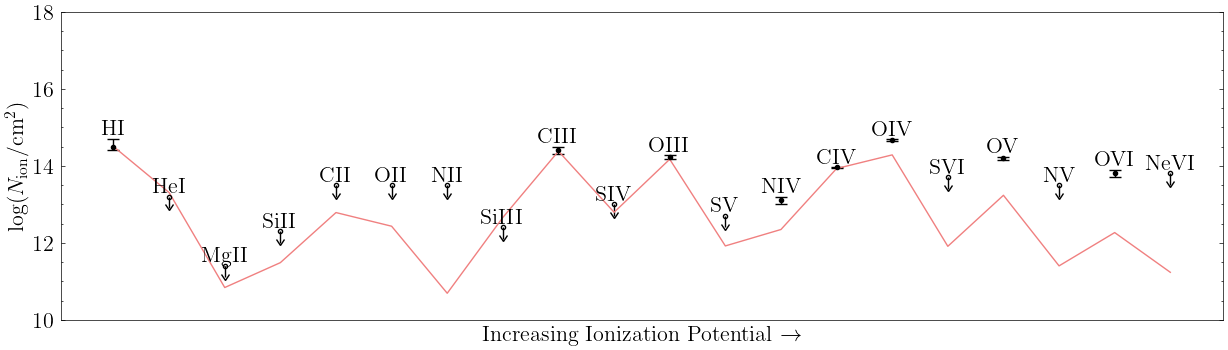

In [41]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [46]:
get_cloud_size(14.1, -4.2, species_logN_interp, -0.2)

27.103825409397203

In [45]:
logN_species_p1_grid = predict_col_dens(logN_dict, logN_HI_test, flat_samples_two_phase['log_hdens_p1'], flat_samples_two_phase['log_metals_p1'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p1'], 'N':flat_samples_two_phase['N_O_p1']})

logN_species_p2_grid = predict_col_dens(logN_dict, flat_samples_two_phase['logN_HI_p2'], flat_samples_two_phase['log_hdens_p2'], flat_samples_two_phase['log_metals_p2'], 
                                                 species_logN_interp, {'C':flat_samples_two_phase['C_O_p2'], 'N':flat_samples_two_phase['N_O_p2']})

logN_species_grid = np.log10(10**logN_species_p1_grid + 10**logN_species_p2_grid)

# Medians and errorbars for plotting
logN_species_p1_med = np.median(logN_species_p1_grid, axis=1)
logN_species_p1_lo = np.percentile(logN_species_p1_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p1_hi = np.percentile(logN_species_p1_grid, 100*cdf_1sig, axis=1)

logN_species_p2_med = np.median(logN_species_p2_grid, axis=1)
logN_species_p2_lo = np.percentile(logN_species_p2_grid, 100*(1-cdf_1sig), axis=1)
logN_species_p2_hi = np.percentile(logN_species_p2_grid, 100*cdf_1sig, axis=1)

logN_species_med = np.median(logN_species_grid, axis=1)
logN_species_lo = np.percentile(logN_species_grid, 100*(1-cdf_1sig), axis=1)
logN_species_hi = np.percentile(logN_species_grid, 100*cdf_1sig, axis=1)

In [46]:
logN_species_p1_med[4], logN_species_p2_med[4]

(14.024110013376974, 13.675554813821496)

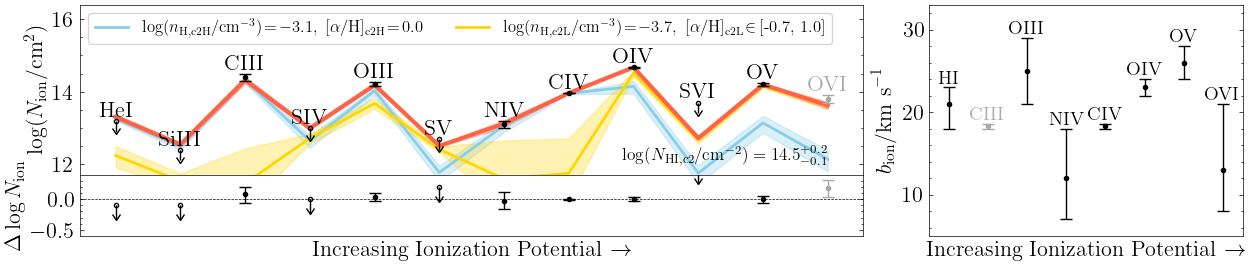

In [51]:
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                               figsize=(15,3.), gridspec_kw={'height_ratios': [2.8,1], 'width_ratios': [2.5, 1]})

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_p1_lo, logN_species_p1_hi,
                color='skyblue', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p1_med, color='skyblue', lw=2, alpha=1)

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_p2_lo, logN_species_p2_hi,
                color='gold', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_p2_med, color='gold', lw=2, alpha=1)

axd['upper left'].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axd['upper left'].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=3, alpha=1)

plot_column_densities_obs(logN_dict, fig, axd['upper left'],
                          gray_out = ['OVI', 'NeVI', 'NeVIII'])

axd['upper left'].set_ylim(11.7,16.4)

axd['upper left'].set_xlabel(None)

axd['upper left'].text(len(logN_dict)-1, 12.1, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 14.5_{-0.1}^{+0.2}$', fontsize=12.5,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2H}/\mathrm{cm}^{-3}) \!=\! -3.1, \ \mathrm{[\alpha/H]_{c2H}}\!=\! 0.0$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2L}/\mathrm{cm}^{-3}) \!=\! -3.7, \ \mathrm{[\alpha/H]_{c2L}}\!\in\!$ [-0.7, 1.0]'))
    
axd['upper left'].legend(handles=handles, loc='upper left', fontsize=12, ncol=2)

plot_column_densities_obs(logN_res_dict, fig, axd['lower left'], gray_out = ['OVI'], label_ions=False, dy=.15)
plot_column_densities_obs(logN_res_up, fig, axd['lower left'], gray_out = ['OVI'], label_ions=False, dy=.15)

axd['lower left'].set_ylim(-.6,.4)
axd['lower left'].axhline(0, linestyle='--', lw=.5)
axd['lower left'].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')


plot_linewidth_obs(b_dict, fig, axd['right'], fs=14, gray_out=['CIII'])
axd['right'].set_xlim(-0.5, len(b_dict)-1+0.5)
axd['right'].set_ylim(5,33)

plt.subplots_adjust(wspace=0.12, hspace=0)  

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)
plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)

Text(0, 0.5, '$\\Delta \\log N_\\mathrm{ion}$')

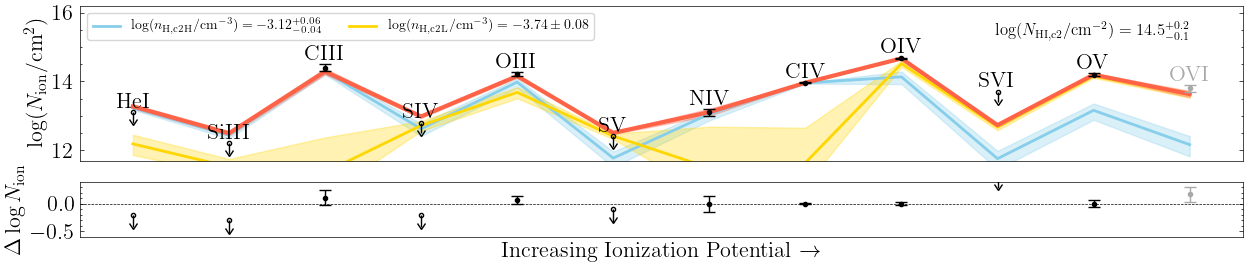

In [112]:
fig, axes = plt.subplots(2, 1, figsize=(15,3.), gridspec_kw={'height_ratios': [2.8, 1]})

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_p1_lo, logN_species_p1_hi,
                color='skyblue', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_p1_med, color='skyblue', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_p2_lo, logN_species_p2_hi,
                color='gold', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_p2_med, color='gold', lw=2, alpha=1)

axes[0].fill_between(np.arange(len(logN_dict)), logN_species_lo, logN_species_hi,
                color='tomato', alpha=.3)
axes[0].plot(np.arange(len(logN_dict)), logN_species_med, color='tomato', lw=3, alpha=1)

plot_column_densities_obs(logN_dict, fig, axes[0],
                          gray_out = ['OVI', 'NeVI', 'NeVIII'])

axes[0].set_ylim(11.7,16.2)

axes[0].set_xlabel(None)

axes[0].text(len(logN_dict)-1, 15.3, r'$\log(N_\mathrm{HI, c2}/\mathrm{cm}^{-2}) = 14.5_{-0.1}^{+0.2}$', fontsize=12,
            horizontalalignment='right')

handles = []

handles.append(mlines.Line2D([], [], lw=2,
                             color='skyblue', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2H}/\mathrm{cm}^{-3}) = -3.12_{-0.04}^{+0.06}$'))

handles.append(mlines.Line2D([], [], lw=2,
                             color='gold', 
                             marker='None',
              linestyle='-', markersize=8, label=r'$\log(n_\mathrm{H, c2L}/\mathrm{cm}^{-3}) = -3.74 \pm 0.08$'))
    
axes[0].legend(handles=handles, loc='upper left', fontsize=10, ncol=2)

plot_column_densities_obs(logN_res_dict, fig, axes[1], gray_out = ['OVI'], label_ions=False, dy=.15)
plot_column_densities_obs(logN_res_up, fig, axes[1], gray_out = ['OVI'], label_ions=False, dy=.15)
axes[1].set_ylim(-.6,.4)
axes[1].axhline(0, linestyle='--', lw=.5)
axes[1].set_ylabel(r'$\Delta \log N_\mathrm{ion}$')

#axes[0].set_xlim(-0.5,7.5)
#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.pdf'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)
#plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/Ions/z={}/z={}_cloudy_c1.png'.format(z_sys, str(z_sys).replace('.', '_')), dpi=300)